In [495]:
# Importação de Bibliotecas
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn.cluster import KMeans
from imblearn.combine import SMOTEENN
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Introdução

Este documento tem como objetivo explorar e produzir resultados utilizando como recurso o banco de dados sobre
percepções e práticas do corpo docente de usar a Wikipedia como recurso de ensino, que está disponível em [wiki4HE](https://archive.ics.uci.edu/ml/datasets/wiki4HE). 

Os dados são referentes a uma pesquisa enviada a professores de duas universidades espanholas (UOC e UPF), contendo 913 respostas e 53 atributos. Dentre os atributos, temos aqueles que são referentes a dados demográficos dos professores (como idade e sexo) e também referentes aos resultados da pesquisa aplicada.


In [2]:
# Leitura dos dados
df = pd.read_csv('wiki4HE.csv', sep=';')

Na tabela abaixo temos a descrição das variáveis referentes aos dados demográficos dos professores, contendo seu título e descrição:

In [31]:
var_demo = ["AGE", "GENDER", "DOMAIN", "PhD", "YEARSEXP", "UNIVERSITY", "UOC_POSITION", "OTHER","OTHER_POSITION", "USERWIKI"]
descr_demo = ['Idade - Numérico',
         'Sexo: 0-mulher e 1-homem',
         "Área de Conhecimento: 1-Artes & Humanas; 2-Ciência; 3-Saúde; 4-Engenharia & Arquitetura; 5-Direito & Politica",
         "PhD: 0-Sim e 1-Não",
         "Anos de experiência como professor universitário - Numérico",
         "Universidade: 1-UOC e 2-UPF",
         "1-Professor; 2-Associado; 3-Assistente; 4-Conferencista; 5-Instrutor; 6-Adjunto", 
         "Se o professor trabalha em tempo parcial na universidade: 1-Sim; 2-Não",
         "Assim como UOC_POSITION, mas para a outra universidade.",
         "Se tem registro na Wikipedia: 0-Não; 1-Sim"]

d = {'DESCRIÇÃO': descr_demo}
print(tabulate(pd.DataFrame(data=d, index = var_demo)))

--------------  -------------------------------------------------------------------------------------------------------------
AGE             Idade - Numérico
GENDER          Sexo: 0-mulher e 1-homem
DOMAIN          Área de Conhecimento: 1-Artes & Humanas; 2-Ciência; 3-Saúde; 4-Engenharia & Arquitetura; 5-Direito & Politica
PhD             PhD: 0-Sim e 1-Não
YEARSEXP        Anos de experiência como professor universitário - Numérico
UNIVERSITY      Universidade: 1-UOC e 2-UPF
UOC_POSITION    1-Professor; 2-Associado; 3-Assistente; 4-Conferencista; 5-Instrutor; 6-Adjunto
OTHER           Se o professor trabalha em tempo parcial na universidade: 1-Sim; 2-Não
OTHER_POSITION  Assim como UOC_POSITION, mas para a outra universidade.
USERWIKI        Se tem registro na Wikipedia: 0-Não; 1-Sim
--------------  -------------------------------------------------------------------------------------------------------------


As demais variáveis referentes a segunda parte da pesquisa, que teve como objetivo coletar informações sobre os diferentes aspectos da Wikipedia em relação ao ensino superior e às opiniões dos professores. Essas perguntas tiveram que ser respondidas através de uma escala Likert, que refere-se ao nível de concordância ou discordância com uma afirmação, sendo 1 igual a "discordo totalmente" e 5 igual a "concordo totalmente". Para maiores detalhes sobre elas, acessar o [link](https://archive.ics.uci.edu/ml/datasets/wiki4HE).

# Análise Exploratória

Inicialmente foram observadas algumas inconsistências na descrição e os dados:
   - A variável OTHER não existe no dataset.
   - A variável OTHER_POSITION possui apenas 0's e 1's, diferente da descrição.
   - Apareceu um nível a mais para a variável DOMAIN não listada na descrição.
    
Observando as variáveis do dataset, a variável OTHER_POSITION provavelmente é a OTHERSTATUS, uma vez que ela contém 0 e 1, assim como a descrição da primeira. O mesmo vale para a variável OTHER com a OTHER_POSITION, mas neste caso temos um nível a mais, o 7. Então é prudente considerar o seguinte:
   - OTHERSTATUS do dataset = OTHER_POSITION da descrição
   - OTHER_POSITION do dataset = OTHER da descrição

Primeiramente é necessário transformar o dataset em numérico e também os valores ? em nulo. Depois disso, temos, para cada coluna, a quantidade de dados faltantes. Observando o resultado podemos notar que as colunas UOC_POSITION, OTHER_POSITION, OTHERSTATUS e Vis2 possuem uma quantidade considerável de dados faltantes (todos mais do que 100).

In [32]:
# Converter todas as colunas para numérico.

df2 = df.replace('?', np.nan)
cols = df.columns
df2[cols] = df2[cols].apply(pd.to_numeric, errors='coerce')

# Soma dos dados faltantes de cada coluna

df2.isnull().sum()

AGE                 0
GENDER              0
DOMAIN              2
PhD                 0
YEARSEXP           23
UNIVERSITY          0
UOC_POSITION      113
OTHER_POSITION    261
OTHERSTATUS       540
USERWIKI            4
PU1                 7
PU2                11
PU3                 5
PEU1                4
PEU2               14
PEU3               97
ENJ1                7
ENJ2               17
Qu1                 7
Qu2                10
Qu3                15
Qu4                22
Qu5                29
Vis1               72
Vis2              117
Vis3                8
Im1                22
Im2                20
Im3                57
SA1                11
SA2                12
SA3                11
Use1               14
Use2               17
Use3                9
Use4               23
Use5               15
Pf1                11
Pf2                 6
Pf3                14
JR1                27
JR2                53
BI1                32
BI2                43
Inc1               35
Inc2      

Abaixo temos as estatísticas descritivas e os histogramas dos dados:

In [167]:
cols_demo = ['AGE','GENDER','DOMAIN','PhD','YEARSEXP','UNIVERSITY','UOC_POSITION','OTHER_POSITION','OTHERSTATUS','USERWIKI']
cols_pesq = ['PU1','PU2','PU3','PEU1','PEU2','PEU3','ENJ1','ENJ2','Qu1','Qu2','Qu3','Qu4','Qu5','Vis1','Vis2','Vis3','Im1',
             'Im2','Im3','SA1','SA2','SA3','Use1','Use2','Use3','Use4','Use5','Pf1','Pf2','Pf3','JR1','JR2','BI1','BI2',
             'Inc1','Inc2','Inc3','Inc4','Exp1','Exp2','Exp3','Exp4','Exp5']
cols_pesq1 = ['PU1','PU2','PU3','PEU1','PEU2','PEU3','ENJ1','ENJ2','Qu1','Qu2','Qu3','Qu4','Qu5','Vis1','Vis2','Vis3','Im1']
cols_pesq2 = ['Im1','Im2','Im3','SA1','SA2','SA3','Use1','Use2','Use3','Use4','Use5','Pf1','Pf2','Pf3','JR1','JR2']
cols_pesq3 = ['BI1','BI2','Inc1','Inc2','Inc3','Inc4','Exp1','Exp2','Exp3','Exp4','Exp5']


In [168]:
df2[cols_demo].describe()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI
count,913.000000,913.000000,911.000000,913.000000,890.000000,913.000000,800.00000,652.000000,373.000000,909.000000
mean,42.246440,0.424973,4.097695,0.464403,10.874157,1.123768,5.40625,1.588957,4.209115,0.137514
std,8.058418,0.494610,1.955636,0.499005,7.451222,0.329497,1.32605,0.492401,2.225034,0.344578
min,23.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000
25%,36.000000,0.000000,2.000000,0.000000,5.000000,1.000000,6.00000,1.000000,2.000000,0.000000
50%,42.000000,0.000000,5.000000,0.000000,10.000000,1.000000,6.00000,2.000000,4.000000,0.000000
75%,47.000000,1.000000,6.000000,1.000000,15.000000,1.000000,6.00000,2.000000,7.000000,0.000000
max,69.000000,1.000000,6.000000,1.000000,43.000000,2.000000,6.00000,2.000000,7.000000,1.000000


In [169]:
df2[cols_pesq1].describe()

,PU1,PU2,PU3,PEU1,PEU2,PEU3,ENJ1,ENJ2,Qu1,Qu2,Qu3,Qu4,Qu5,Vis1,Vis2,Vis3,Im1
count,906.000000,902.000000,908.000000,909.000000,899.000000,816.000000,906.000000,896.000000,906.000000,903.000000,898.000000,891.000000,884.000000,841.000000,796.000000,905.000000,891.000000
mean,3.137969,3.149667,3.450441,4.356436,4.045606,3.383578,3.794702,3.821429,3.195364,3.421927,2.981069,3.237935,3.041855,2.945303,3.069095,2.026519,2.478114
std,1.009214,0.990966,1.048320,0.780062,0.828992,0.915403,0.969031,0.886540,0.874703,0.864581,0.872392,1.082837,0.963344,0.911229,0.856496,1.159495,0.975154
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.000000,2.000000
50%,3.000000,3.000000,3.000000,5.000000,4.000000,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [170]:
df2[cols_pesq2].describe()

,Im1,Im2,Im3,SA1,SA2,SA3,Use1,Use2,Use3,Use4,Use5,Pf1,Pf2,Pf3,JR1,JR2
count,891.000000,893.000000,856.000000,902.000000,901.000000,902.000000,899.000000,896.000000,904.000000,890.000000,898.000000,902.000000,907.000000,899.000000,886.000000,860.000000
mean,2.478114,3.294513,2.887850,4.190687,4.129856,4.383592,2.115684,1.831473,2.661504,2.553933,3.305122,2.273836,2.861080,2.550612,3.698646,3.108140
std,0.975154,1.040407,1.001305,0.842280,0.964830,0.801827,1.094616,1.063121,1.213810,1.191416,1.092386,1.282237,1.313244,1.296924,1.079097,1.200962
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,2.000000,4.000000,4.000000,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,3.000000,2.000000
50%,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,2.000000,1.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000
75%,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,3.000000,2.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,5.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [171]:
df2[cols_pesq3].describe()

,BI1,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
count,881.000000,870.000000,878.000000,878.000000,876.000000,871.000000,900.000000,902.000000,900.000000,899.000000,900.000000
mean,2.952327,2.989655,3.746014,3.461276,3.441781,3.490241,3.001111,3.492239,3.651111,1.588432,2.486667
std,1.062800,1.114249,1.106816,1.135206,1.158339,1.195618,1.186220,1.112658,1.118382,0.944872,1.353461
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000,1.000000
50%,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,1.000000,2.000000
75%,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


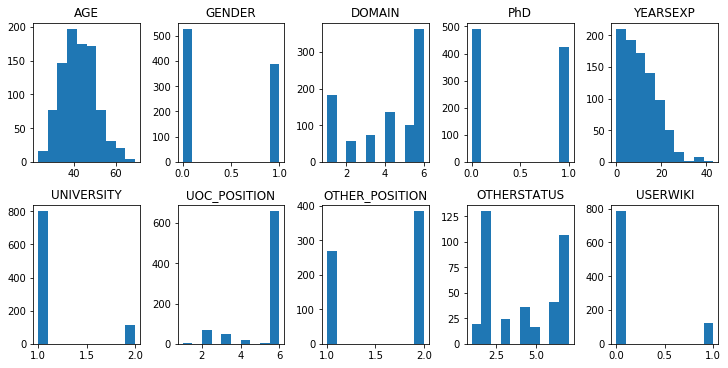

In [172]:
half_cols = int(len(cols_demo)/2)

f = plt.figure(constrained_layout=True, figsize=(10,5))
spec = f.add_gridspec(ncols=5, nrows=2)

for row in range(2):
    for i in range(half_cols):
        if row == 0:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_demo[i]])
            ax.title.set_text(cols_demo[i])
        else:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_demo[i + half_cols]])
            ax.title.set_text(cols_demo[i + half_cols])

Observando os histogramas acima podemos extrair algumas informações interessantes. Primeiramente que tem muitos professores na área de conhecimendo que não foi listada na descrição dos dados. Além disso, temos que a grande maioria é da universidade UOC e que não é usuário da Wikipedia.

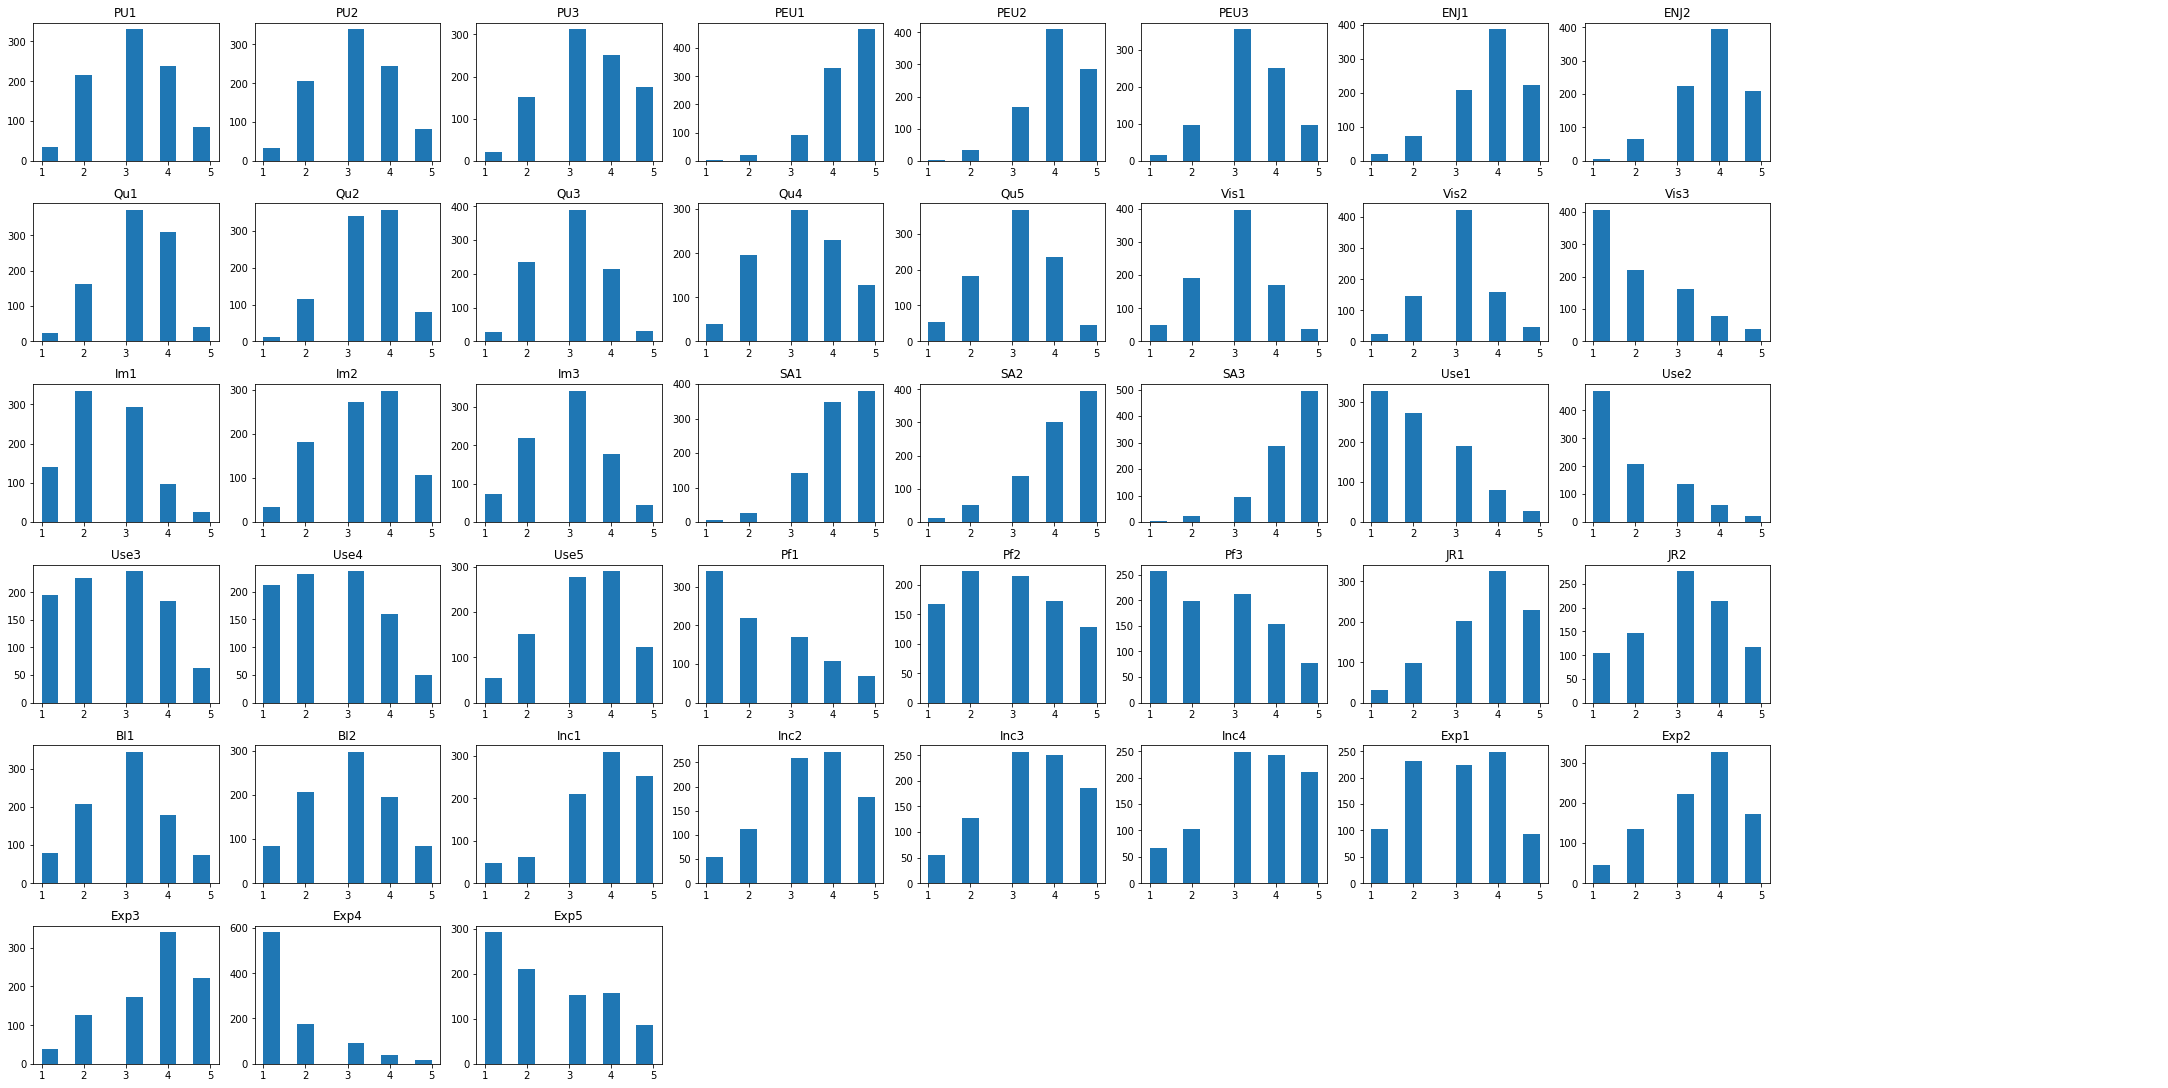

In [173]:
half_cols = int(len(cols_pesq)/5)

f = plt.figure(constrained_layout=True, figsize=(30,15))
spec = f.add_gridspec(ncols=10, nrows=6)

for row in range(6):
    for i in range(half_cols):
        if row == 0:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i]])
            ax.title.set_text(cols_pesq[i])
        elif row == 1:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i + half_cols]])
            ax.title.set_text(cols_pesq[i + half_cols])
        elif row == 2:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i + half_cols*2]])
            ax.title.set_text(cols_pesq[i + half_cols*2])
        elif row == 3:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i + half_cols*3]])
            ax.title.set_text(cols_pesq[i + half_cols*3])
        elif row == 4:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i + half_cols*4]])
            ax.title.set_text(cols_pesq[i + half_cols*4])
        elif row == 5 and i < 3:
            ax = f.add_subplot(spec[row, i])
            ax.hist(df2[cols_pesq[i + half_cols*5]])
            ax.title.set_text(cols_pesq[i + half_cols*5])
        else:
            pass

Observando os histogramas acima podemos notar que boa parte deles indicam que as distribuições estão próximas da Gaussiana. E, pela matriz de correlação abaixo, não temos problemas de multicolinearidade aparentemente.

In [176]:
df2.corr()

,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
AGE,1.000000,-0.126717,-0.061879,0.113846,0.555296,0.026492,-0.024764,-0.006654,-0.311076,0.009610,...,-0.011025,-0.051388,-0.010381,0.017291,-0.030799,-0.034984,-0.069433,-0.136753,-0.036488,0.007194
GENDER,-0.126717,1.000000,-0.044187,-0.058591,-0.091633,-0.013604,-0.030387,0.016582,0.133120,-0.090995,...,-0.115572,0.109972,0.069580,0.118577,0.072155,-0.131774,-0.084813,-0.069838,-0.086270,-0.036406
DOMAIN,-0.061879,-0.044187,1.000000,0.034543,0.058320,-0.020513,-0.043554,-0.156053,0.046111,-0.000660,...,-0.073921,-0.076670,-0.056019,-0.084780,-0.045870,-0.094052,-0.079106,0.001487,-0.013203,-0.080442
PhD,0.113846,-0.058591,0.034543,1.000000,0.464591,0.163536,-0.336817,-0.522686,-0.555066,-0.026695,...,-0.086516,-0.105618,-0.049976,-0.084029,-0.033852,0.016035,0.026501,-0.044064,-0.077849,-0.141563
YEARSEXP,0.555296,-0.091633,0.058320,0.464591,1.000000,0.153800,-0.218629,-0.475150,-0.544762,-0.030557,...,-0.068430,-0.080205,-0.040935,-0.057320,-0.054668,-0.019938,-0.024596,-0.078026,-0.111370,-0.094394
UNIVERSITY,0.026492,-0.013604,-0.020513,0.163536,0.153800,1.000000,NaN,NaN,0.014406,0.005816,...,-0.024675,-0.151933,-0.122923,-0.114376,-0.105696,0.056877,0.110349,0.067914,-0.015453,-0.124218
UOC_POSITION,-0.024764,-0.030387,-0.043554,-0.336817,-0.218629,NaN,1.000000,NaN,NaN,-0.041748,...,-0.068383,-0.063400,-0.087405,0.056670,-0.003712,-0.070913,-0.075075,-0.037860,0.048651,-0.063041
OTHER_POSITION,-0.006654,0.016582,-0.156053,-0.522686,-0.475150,NaN,NaN,1.000000,NaN,0.068798,...,0.158552,0.064757,-0.001108,0.067712,0.030137,0.108197,0.071014,0.083696,0.091679,0.191222
OTHERSTATUS,-0.311076,0.133120,0.046111,-0.555066,-0.544762,0.014406,NaN,NaN,1.000000,0.002837,...,0.029668,0.144442,0.023804,0.062968,0.073067,0.015104,0.024168,0.037541,0.163187,0.187670
USERWIKI,0.009610,-0.090995,-0.000660,-0.026695,-0.030557,0.005816,-0.041748,0.068798,0.002837,1.000000,...,0.237548,0.027545,-0.002129,0.016894,0.060828,0.204303,0.179806,0.174648,0.436505,0.216771


### Tratativas

Ao remover as colunas demográficas com grande volume de nulos do dataset ficamos com poucos registros com informações demográficas faltantes. Portanto, elas foram excluílas do dataset.

Para as variáveis de pesquisa é uma boa opção substituir o nulo pela média de cada coluna. Neste caso remover as observações resulta em excluir mais de um terço do banco de dados, o que pode prejudicar os resultados.

In [193]:
df3 = df2.drop(columns = ['UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS'], axis=1)
cols_demo2 = ['AGE','GENDER','DOMAIN','PhD','YEARSEXP','UNIVERSITY','USERWIKI']
df3.dropna(subset=cols_demo2, inplace = True)
df3.isnull().sum()

AGE             0
GENDER          0
DOMAIN          0
PhD             0
YEARSEXP        0
UNIVERSITY      0
USERWIKI        0
PU1             7
PU2            11
PU3             5
PEU1            4
PEU2           14
PEU3           93
ENJ1            7
ENJ2           16
Qu1             7
Qu2            10
Qu3            15
Qu4            20
Qu5            27
Vis1           69
Vis2          113
Vis3            8
Im1            21
Im2            18
Im3            54
SA1             9
SA2            12
SA3            11
Use1           13
Use2           15
Use3            9
Use4           21
Use5           15
Pf1            11
Pf2             6
Pf3            12
JR1            24
JR2            47
BI1            29
BI2            39
Inc1           33
Inc2           32
Inc3           35
Inc4           38
Exp1           11
Exp2           10
Exp3           12
Exp4            9
Exp5           12
dtype: int64

In [199]:
# tamanho do dataset se remover todos os valores nulos
len(df3.dropna())

608

In [200]:
df3.fillna(df3.mean(), inplace=True)
df3.isnull().sum()

## Variáveis ENJ1 e ENJ2

Para analisar as respostas dos usuários em relação às variáveis ENJ1 e ENJ2 primeiramente precisamos fazer algumas tratativas nos dados. Para tal, primeiramente vamos aplicar o algoritmo k-means para agrupar os professores em clusters. Feito isso, podemos analisar o comportamento de cada cluster em relação a cada uma das variáveis.

Além disso, vamos transformar a escala likert em uma resposta binária (0 e 1) considerando valores maiores do que 3 como 1, valores menores do que 3 como 0 e 3 como nulo e removendo do dataset para não atrapalhar na modelagem.

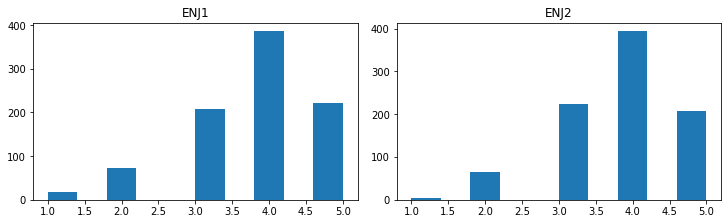

In [185]:
f = plt.figure(constrained_layout=True, figsize=(10,3))
spec = f.add_gridspec(ncols=2, nrows=1)

ax = f.add_subplot(spec[0, 0])
ax.hist(df2.ENJ1)
ax.title.set_text('ENJ1')

ax = f.add_subplot(spec[0, 1])
ax.hist(df2.ENJ2)
ax.title.set_text('ENJ2')

## K-means

Primeiramente precisamos determinar o número de clusters. Para tal, utilizaremos o método de Elbow, que consiste em treinar vários modelos aumentando o número de clusters e comparando o valor de WCSS (inertia_). Após isso, temos um gráfico com as dimensões número de clusters e WCSS. Olhando este gráfico podemos escolher o número de clusters no ponto onde a curva não apresenta muita variação quando aumenta o número de clusters. No caso abaixo vamos escolher o número 4.

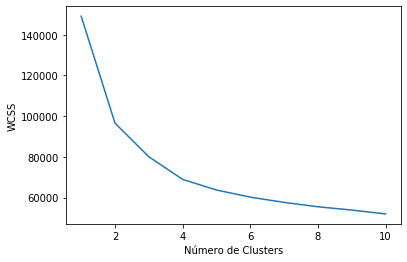

In [205]:
cols_kmean= ['AGE','GENDER','DOMAIN','PhD','YEARSEXP','UNIVERSITY','USERWIKI','PU1','PU2','PU3','PEU1','PEU2','PEU3',
             'Qu1','Qu2','Qu3','Qu4','Qu5','Vis1','Vis2','Vis3','Im1','Im2','Im3','SA1','SA2','SA3','Use1','Use2',
             'Use3','Use4','Use5','Pf1','Pf2','Pf3','JR1','JR2','BI1','BI2','Inc1','Inc2','Inc3','Inc4','Exp1','Exp2',
             'Exp3','Exp4','Exp5']
X = df3[cols_kmean]
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

In [209]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
df3['CLUSTER'] = kmeans.fit_predict(X)

Observando os centróides dos clusters podemos notar, por exemplo, que o cluster 2 se concentra os professores com mais anos de experiência enquanto que o cluster 0 aqueles com menos. Também que os cluster 2 e 3 estão concentrados os professores com PhD, principalmente o 3.

In [227]:
kmeans.cluster_centers_

array([[34.44036697,  0.49235474,  4.15902141,  0.33944954,  5.42201835,
         1.12538226,  0.13761468,  3.18430127,  3.15029146,  3.50764526,
         4.42616987,  4.13805707,  3.478072  ,  3.28316371,  3.54335692,
         3.05470843,  3.2717965 ,  3.17822544,  2.98405738,  3.13427136,
         1.99708138,  2.56701283,  3.32289275,  2.99886287,  4.28134557,
         4.27909315,  4.41896024,  2.23045198,  1.87715913,  2.64114756,
         2.60158993,  3.30336391,  2.39919104,  3.16731899,  2.62550662,
         3.71889951,  3.20600965,  3.04547501,  3.10688905,  3.87523151,
         3.45469668,  3.44461234,  3.56104835,  3.10092793,  3.59171691,
         3.79098402,  1.67889908,  2.47686455],
       [48.75706215,  0.36723164,  3.71186441,  0.21468927,  6.10734463,
         1.04519774,  0.15819209,  3.07570493,  3.10579969,  3.34408064,
         4.2639271 ,  3.96126927,  3.37572762,  3.04178732,  3.2637159 ,
         2.91463082,  3.25521701,  2.84956475,  2.91654204,  3.00074647,
   

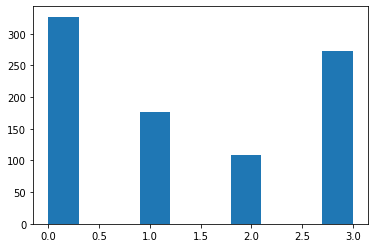

In [216]:
# Distribuição dos clusters
plt.hist(df3.CLUSTER)
plt.show()

Agora temos cada observação atribuída a um grupo (cluster) de acordo com a proporção acima, onde pondemos notar que o cluster 0 possui o maior volume de observações enquanto que o cluster 2 o menor volume. Agora podemos voltar a analisar as variáveis ENJ1 e ENJ2.

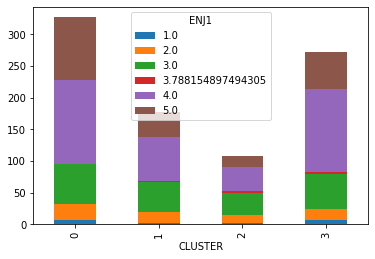

In [292]:
df3.groupby(['CLUSTER','ENJ1']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

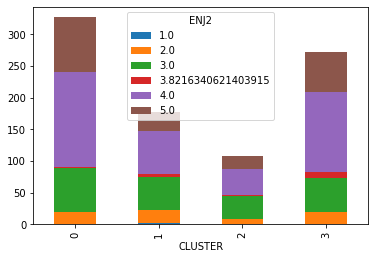

In [293]:
df3.groupby(['CLUSTER','ENJ2']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

Observando os dois gráficos acima podemos tirar algumas conclusões. Em relação à variável ENJ1, temos que os clusters 0 e 3 concentram a maioria dos professores que responderam mais do que 3, significando que acreditam que a Wikipedia estimula a curiosidade para estes grupos. O mesmo comportamento acontece com a variável ENJ2, significando que os mesmos grupos também acham que usar a Wikipedia é divertido.

## Modelagem predidiva das variáveis ENJ1 e ENJ2

Primeiramente vamos transformar as variáveis resposta em binárias para podermos criar modelos de classificação. Para tal, serão criados dois datasets, um para cada variável, e de cada um será removido os valores nulos obtidos após a conversão. Após isso será realizada a normalização dos dados, separação em base de teste e treino e serão treinados os modelos árvore de decisão, regressão logística e knn para comparação dos resultados. A medida que será avaliada é a acurácia.

Após feita a transformação é fácil perceber que temos um problema de balanceamento de classes. Para resolver podemos escolher algumas estratégias, como aplicar um algoritmo de balanceamento de classes (SMOTEENN), uma menos "ofensiva" que consiste em modificar a regra para "binarizar" o banco de dados, passando a ser 1 apenas quem respondeu 5 no questionário ou então não descartar o 3, transformando em 0. Esta última opção, apesar de interessante, resultaria em descartar muita informação, uma vez que a quantidade de professores que assinalaram 3 é grande.
Como estamos interessados em predizer aqueles que dão uma resposta positiva para o questionário (4 e 5), então não é errado transformar valores menores do que 4 em 0, pois quem assinalou 3 não é positivo de acordo com a escala. Vamos testar essa transformação a seguir:

In [504]:
df_enj1 = df3.drop(columns=['CLUSTER'], axis=1).copy()
df_enj2 = df3.drop(columns=['CLUSTER'], axis=1).copy()


df_enj1.loc[df_enj1['ENJ1'] < 4, 'ENJ1'] = 0
df_enj1.loc[df_enj1['ENJ1'] >= 4, 'ENJ1'] = 1
df_enj2.loc[df_enj2['ENJ2'] < 4, 'ENJ2'] = 0
df_enj2.loc[df_enj2['ENJ2'] >= 4, 'ENJ2'] = 1

df_enj1.dropna(inplace=True)
df_enj2.dropna(inplace=True)

In [505]:
df_enj1.ENJ1.value_counts()

1.0    586
0.0    299
Name: ENJ1, dtype: int64

In [506]:
df_enj2.ENJ2.value_counts()

1.0    586
0.0    299
Name: ENJ2, dtype: int64

Ainda está muito desbalanceado. Neste caso vamos utilizar a técnica de reamostragem SMOTEENN para melhorar a distribuição. Então vamos fazer os seguintes passos:

- Balancear as classes;
- Aplicar o algoritmo de padronização dos dados StandardScaler;
- Aplicar os modelos knn, DecisionTree e LogisticRegression e comparar os resultados utilizando a acurácia. Entregando o melhor modelo encontrado no final. Para garantir que não teremos problemas com overfit, utilizaremos o algoritmo KFold na modelagem.

In [511]:
# Funções utilizadas na modelagem:

def balancear_classes(X,Y):
    
    sme = SMOTEENN(random_state=42,sampling_strategy='all')
    X_res, y_res = sme.fit_resample(X,Y)

    return X_res, y_res

def padronizar(X):

    X1 = X.drop(columns=['GENDER', 'PhD', 'UNIVERSITY', 'USERWIKI'], axis=1)
    X2 = X[['GENDER', 'PhD', 'UNIVERSITY', 'USERWIKI']]
    
    scaler = StandardScaler()
    scaler.fit(X2)
    X_std = scaler.transform(X2)
    X_std_df = pd.DataFrame(X_std, index=X2.index, columns=X2.columns).join(X1)
    
    return X_std_df

def modelar(df, coluna):
    Y = df[coluna]
    X = df.drop(columns = [coluna], axis = 1)
    
    #OBJETOS DOS MODELOS
    knn = KNeighborsClassifier()
    dtree = DecisionTreeClassifier(criterion = 'entropy',
                               min_weight_fraction_leaf = .06,
                               min_samples_leaf = .06)
    logreg = LogisticRegression(solver='lbfgs')
    
    mods =[knn, dtree, logreg]
    
    nome_modelo = {type(dtree): 'arvore_decisao',
           type(logreg): 'regressao_logistica',
           type(knn): 'knn'
          }
    
    media = 0
    kfold = KFold(n_splits=10)
    mod_final = None

    for mod in mods:
        X_padr = padronizar(X)
        X_balanc, Y_balanc = balancear_classes(X_padr, Y)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            score_novo = cross_val_score(mod, X_balanc, Y_balanc, cv=kfold)
        media_novo = score_novo.mean()

        if media_novo > media:
            media = media_novo
            mod_final = mod
        else:
            pass
    
    print('Melhor modelo: %s' % nome_modelo[type(mod_final)])
    print("Acurácia do modelo final: %0.2f" % (media))

In [512]:
# Separando apenas as colunas demográficas para modelar a resposta

df_enj1_modelar = df_enj1[['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY', 'USERWIKI', 'ENJ1']]
df_enj2_modelar = df_enj2[['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY', 'USERWIKI', 'ENJ2']]

In [513]:
modelar(df_enj1_modelar, 'ENJ1')

Melhor modelo: knn
Acurácia do modelo final: 0.79


In [514]:
modelar(df_enj2_modelar, 'ENJ2')

Melhor modelo: knn
Acurácia do modelo final: 0.81


Ao final, temos um modelo para predizer as respostas das variáveis ENJ1 e ENJ2 com boa capacidade preditiva.

# Considerações Finais

Neste documento apresentamos um estudo do dataset wiki4HE, onde foram realizados estudos exploratórios e preditivos, assim como tratamento dos dados.

Na análise exploratória foi possível identificar algumas particularidades do dataset, como a distribuição de homens e mulheres próxima ou o alto volume de professores que não utilizam a Wikipedia. Na parte de pré-processamento foram tratados os valores faltantes do dataset e as inconsistências entre a descrição e os dados.

Na etapa de modelagem foram encontrados 4 clusters para agrupamento dos professores e foram feitas análises destes em relação às variáveis ENJ1 e ENJ2. Ao final, estas variáveis foram convertidas em binárias e foram encontrados modelos para encontrar perfis de professores que possuem opiniões positivas para as variáveis ENJ1 e ENJ2 utilizando apenas suas informações demográficas, onde foram encontrados modelos com boa capacidade preditiva (aproximadamente 80%).